In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_score, LeaveOneOut

from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('Auto.csv')
df.shape

(397, 9)

In [5]:
df.head(4)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


In [13]:
# Convert object datatype of horsepower to float datatype 
df['horsepower'] =  pd.to_numeric(df['horsepower'],errors='coerce')

In [14]:
# To see if we have any nan value
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [15]:
df.dropna(inplace=True)
print(df.shape)
df.isna().sum()

(392, 9)


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [165]:
x = df['horsepower']
y = df['mpg']

In [166]:
def model_MSE(x, y, order): 
    
    # Split 50% of data into training and 50% into test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 42, shuffle = False)
    
    df_train = pd.DataFrame({'mpg': y_train, 'horsepower': x_train})
    
    formula = 'mpg ~ 1 +' + '+'.join(['I(horsepower**{})'.format(i) for i in np.arange(1, order + 1)])
    
    dic = {1: 'st', 2: 'nd', 3: 'rd'}
    if order < 4:
        suffix = dic[order]
    else: 
        suffix = 'th'
   
    # Create the polynomial model   
    model = smf.ols(formula = formula, data = df_train)
    
    # Fit the model
    result = model.fit()
    
    # Predict mpg on test dataset
    y_test_prediction = result.predict(x_test)
    
    # Mean squarred Error
    MSE = np.mean(y_test - y_test_prediction)**2
    
    # Print Mean Squared Error
    print('MSE of {}{} order polynomial fit function: {}'.format(order, suffix, MSE))
    
    return MSE
  

In [167]:
# MSE of evaluation dataset for a linear model
model_MSE(x, y, 1)  

# MSE of evaluation dataset for a quadratic model
model_MSE(x, y, 2) 

# MSE of evaluation dataset for a cubic model
model_MSE(x, y, 3) 

MSE of 1st order polynomial fit function: 24.521263367513804
MSE of 2nd order polynomial fit function: 22.918389468935647
MSE of 3rd order polynomial fit function: 22.913525056358036


22.913525056358036

MSE of 1st order polynomial fit function: 24.521263367513804
MSE of 2nd order polynomial fit function: 22.918389468935647
MSE of 3rd order polynomial fit function: 22.913525056358036
MSE of 4th order polynomial fit function: 22.82292912275339
MSE of 5th order polynomial fit function: 21.895950359774318
MSE of 6th order polynomial fit function: 22.201487655685643
MSE of 7th order polynomial fit function: 21.603512812872935
MSE of 8th order polynomial fit function: 22.98541068977495
MSE of 9th order polynomial fit function: 31.63552887834209


<IPython.core.display.Javascript object>


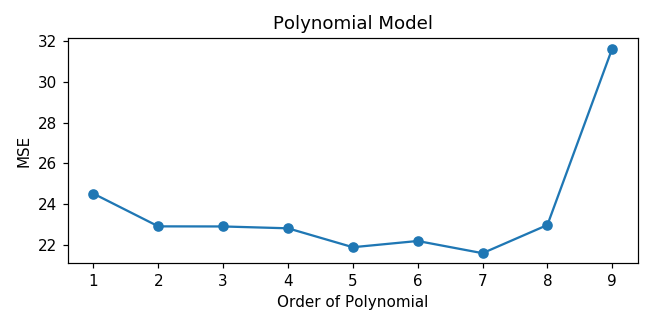

In [168]:
%matplotlib notebook

MSE = []
order_range = range(1, 10)
for order in order_range:
    MSE.append(model_MSE(x, y, order))
    
plt.figure(figsize=(6, 3))
plt.plot(order_range, MSE, marker = 'o')
plt.xlabel('Order of Polynomial')
plt.ylabel('MSE')
plt.title('Polynomial Model')
plt.tight_layout()
plt.savefig('Polynomial_model.png')
    

### Leave-One-Out Cross-Validation

In [169]:
for order in range(1, 6):
    
    
    model = LinearRegression()
    
    
    poly_reg = PolynomialFeatures(degree=order) 
    
    
    x_poly = poly_reg.fit_transform(x)
    
    # Fit the model
    model.fit(x_poly,y)
    
    cross_val_score(model, x_poly, y, cv=len())
    
    # Predict 
    y_test_prediction = result.predict(x_test)
    
    # Mean squarred Error
    MSE = np.mean(y_test - y_test_prediction)**2


ValueError: Expected 2D array, got 1D array instead:
array=[130. 165. 150. 150. 140. 198. 220. 215. 225. 190. 170. 160. 150. 225.
  95.  95.  97.  85.  88.  46.  87.  90.  95. 113.  90. 215. 200. 210.
 193.  88.  90.  95. 100. 105. 100.  88. 100. 165. 175. 153. 150. 180.
 170. 175. 110.  72. 100.  88.  86.  90.  70.  76.  65.  69.  60.  70.
  95.  80.  54.  90.  86. 165. 175. 150. 153. 150. 208. 155. 160. 190.
  97. 150. 130. 140. 150. 112.  76.  87.  69.  86.  92.  97.  80.  88.
 175. 150. 145. 137. 150. 198. 150. 158. 150. 215. 225. 175. 105. 100.
 100.  88.  95.  46. 150. 167. 170. 180. 100.  88.  72.  94.  90.  85.
 107.  90. 145. 230.  49.  75.  91. 112. 150. 110. 122. 180.  95. 100.
 100.  67.  80.  65.  75. 100. 110. 105. 140. 150. 150. 140. 150.  83.
  67.  78.  52.  61.  75.  75.  75.  97.  93.  67.  95. 105.  72.  72.
 170. 145. 150. 148. 110. 105. 110.  95. 110. 110. 129.  75.  83. 100.
  78.  96.  71.  97.  97.  70.  90.  95.  88.  98. 115.  53.  86.  81.
  92.  79.  83. 140. 150. 120. 152. 100. 105.  81.  90.  52.  60.  70.
  53. 100.  78. 110.  95.  71.  70.  75.  72. 102. 150.  88. 108. 120.
 180. 145. 130. 150.  68.  80.  58.  96.  70. 145. 110. 145. 130. 110.
 105. 100.  98. 180. 170. 190. 149.  78.  88.  75.  89.  63.  83.  67.
  78.  97. 110. 110.  48.  66.  52.  70.  60. 110. 140. 139. 105.  95.
  85.  88. 100.  90. 105.  85. 110. 120. 145. 165. 139. 140.  68.  95.
  97.  75.  95. 105.  85.  97. 103. 125. 115. 133.  71.  68. 115.  85.
  88.  90. 110. 130. 129. 138. 135. 155. 142. 125. 150.  71.  65.  80.
  80.  77. 125.  71.  90.  70.  70.  65.  69.  90. 115. 115.  90.  76.
  60.  70.  65.  90.  88.  90.  90.  78.  90.  75.  92.  75.  65. 105.
  65.  48.  48.  67.  67.  67.  67.  62. 132. 100.  88.  72.  84.  84.
  92. 110.  84.  58.  64.  60.  67.  65.  62.  68.  63.  65.  65.  74.
  75.  75. 100.  74.  80.  76. 116. 120. 110. 105.  88.  85.  88.  88.
  88.  85.  84.  90.  92.  74.  68.  68.  63.  70.  88.  75.  70.  67.
  67.  67. 110.  85.  92. 112.  96.  84.  90.  86.  52.  84.  79.  82.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [146]:
x = df['horsepower'].values
y = df['mpg'].values
x = x[:,np.newaxis]



MSE_list = []
order_range = range(1, 10)
for order in order_range:
    
    # create loocv procedure
    cv = LeaveOneOut()
    
    # Create a linear model
    model = LinearRegression()
    
    # Polynomial features
    poly_reg = PolynomialFeatures(degree=order)
    
    # fit and transform x
    x_poly = poly_reg.fit_transform(x)

    cv.get_n_splits(x_poly)

    y_true, y_pred = [], []
    for train_ix, test_ix in cv.split(x_poly):
        x_train, x_test = x_poly[train_ix, :], x_poly[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        model.fit(x_train, y_train)
        # evaluate model
        y_prediction = model.predict(x_test)

        y_true.append(y_test[0])
        y_pred.append(y_prediction[0])

    SE = [(i - j)**2 for i, j in zip(y_true, y_pred)]
    MSE_LOOCV = np.mean(SE)
    MSE_list.append(MSE_LOOCV)
MSE_list

[24.231513517929226,
 19.248213124489748,
 19.334984064102827,
 19.424430309129928,
 19.033207332300268,
 19.00937528420976,
 19.125997452931603,
 19.224238673880407,
 19.133171458462897]

<IPython.core.display.Javascript object>


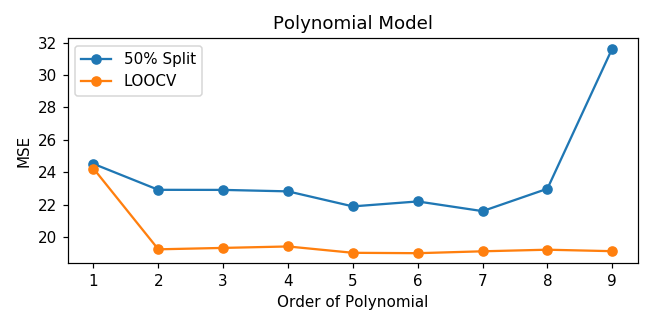

In [145]:
%matplotlib notebook
plt.figure(figsize=(6, 3))
plt.plot(order_range, MSE, marker = 'o', label = '50% Split')
plt.plot(order_range, MSE_list, marker = 'o', label = 'LOOCV')
plt.xlabel('Order of Polynomial')
plt.ylabel('MSE')
plt.title('Polynomial Model')
plt.legend()
plt.tight_layout()
plt.savefig('Polynomial_model_LOOCV.png')

### k-Fold Cross-Validation

In [162]:
x = df['horsepower'].values
y = df['mpg'].values
x = x[:,np.newaxis]

MSE_CV = []
order_range = range(1, 10)
for order in order_range:
    

    
    # Create a linear model
    model = LinearRegression()
    
    # Polynomial features
    poly_reg = PolynomialFeatures(degree=order)
    
    # fit and transform x
    x_poly = poly_reg.fit_transform(x)

    scores = cross_val_score(model, x_poly, y, cv=10, scoring='neg_mean_squared_error')

    MSE_CV.append(-scores.mean())
MSE_CV

[27.439933652339864,
 21.235840055801578,
 21.336606183492037,
 21.353886998802206,
 20.905617540874637,
 20.783345335487972,
 20.953456126709444,
 21.07716809185521,
 21.036900081004017]

<IPython.core.display.Javascript object>


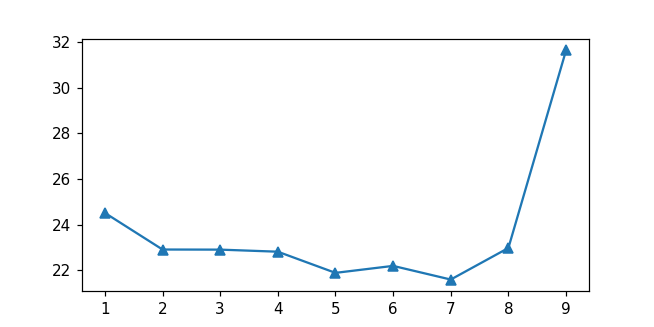

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

In [163]:
%matplotlib notebook
plt.figure(figsize=(6, 3))
plt.plot(order_range, MSE, marker = '^', label = '50% Split')
plt.plot(order_range, MSE_list, marker = 'v', label = 'LOOCV')
plt.plot(order_range, MSE_CV, marker = 'o', label = '10 Fold CV')
plt.xlabel('Order of Polynomial')
plt.ylabel('MSE')
plt.title('Polynomial Model')
plt.legend()
plt.tight_layout()
plt.savefig('Polynomial_model_LOOCV.png')